# **1. Introduction**

In this project, we will perform a forecasting on Apple Inc. stock price for the 182 days ahead (6 months). The original dataset can be personally downloaded from [Nasdaq](https://www.nasdaq.com/market-activity/stocks/aapl/historical). We will also demonstrate the implementation of a newly developed Python package for handling time series forecasting called `AbstrakTS`, which can be imported from [GitHub](https://github.com/rizalpurnawan23/AbstrakTS).

# **2. Preparing the Notebook**

We will first import the necessary packages into our note book. We will also need to install `abstrakTS` package from [GitHub](https://github.com/rizalpurnawan23/AbstrakTS).

In [1]:
# Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The package `abstrakTS` is installed and imported as follows:

In [2]:
# Installing abstrakTS:
!pip install git+https://github.com/rizalpurnawan23/AbstrakTS.git
    
# Importing AbstrakTS from abstrakTS:
from abstrakTS.abstrakTS import AbstrakTS

  Cloning https://github.com/rizalpurnawan23/AbstrakTS.git to /tmp/pip-req-build-qv3pdc66
  Running command git clone --filter=blob:none --quiet https://github.com/rizalpurnawan23/AbstrakTS.git /tmp/pip-req-build-qv3pdc66
  Resolved https://github.com/rizalpurnawan23/AbstrakTS.git to commit 6a930b593ab8d8389ab6301ddb925332b79abc1d
  Preparing metadata (setup.py) ... done
  Created wheel for abstrakTS: filename=abstrakTS-0.0.5-py3-none-any.whl size=10932 sha256=783833dc16af3e28e21fe561e524019a202604712a5e473c4e9b7f1cc18a74d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-hiek3q9v/wheels/d3/6b/e1/371712f584d132c4b550c8aa3f1fa2cbc40ced79762c067413
Successfully built abstrakTS


`AbstrakTS` from `abstrakTS.abstrakTS` is a Python class. For the use in this notebook, we instantiate the class as follows:

In [3]:
# Instantiating `AbstrakTS`:
ats = AbstrakTS()

# **3. Apple Stock Price Dataset**

Now let us import the Apple stock price history dataset and then observe the data.

In [4]:
# Path of the dataset:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        
# Loading the dataset:
apple_df = pd.read_csv(path, parse_dates= ["Date"])
apple_df.head(10)

Date Close/Last    Volume      Open       High       Low
0 2024-01-12    $185.92  40477780   $186.06    $186.74   $185.19
1 2024-01-11    $185.59  49128410   $186.54    $187.05   $183.62
2 2024-01-10    $186.19  46792910   $184.35    $186.40   $183.92
3 2024-01-09    $185.14  42841810   $183.92    $185.15   $182.73
4 2024-01-08    $185.56  59144470  $182.085    $185.60   $181.50
5 2024-01-05    $181.18  62379660   $181.99    $182.76   $180.17
6 2024-01-04    $181.91  71983570   $182.15  $183.0872   $180.88
7 2024-01-03    $184.25  58414460   $184.22    $185.88   $183.43
8 2024-01-02    $185.64  82488670   $187.15    $188.44  $183.885
9 2023-12-29    $192.53  42672150   $193.90    $194.40  $191.725

The basic information about the dataset can be observed as follows:

In [5]:
# Information of Apple dataset:
apple_info = pd.DataFrame(
    {
        "Columns": apple_df.columns,
        "Nullity Count": list(apple_df.isnull().sum()),
        "Dtype": list(apple_df.dtypes)
    }
)
apple_info

Columns  Nullity Count           Dtype
0        Date              0  datetime64[ns]
1  Close/Last              0          object
2      Volume              0           int64
3        Open              0          object
4        High              0          object
5         Low              0          object

From the information above, we confirm that there are no missing values in the dataset. The only problem is that the data types for `Open`, `High`, `Low` and`Close/Last` are objects. We have to transform the types into floating point numbers. Also, we wish to make the arrangement of the columns much more well-ordered and simplified. The transformation is conducted in the following cell:

In [6]:
# Transforming Apple dataset:
def transform_apple(df):
    # Reordering the columns:
    new_df = pd.DataFrame(
        df, columns= ["Date", "Open", "High", "Low", "Close/Last", "Volume"]
    )
    
    # Changing `Close/Last` into simply `Close`:
    new_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
    
    # Transforming the data types of objects into float:
    for col in new_df.columns[1:]:
        if col != "Volume":
            new_df[col] = [float(x.replace("$", "")) for x in new_df[col]]
    
    # Sorting the dataframe based on `Date` ascending:
    new_df = new_df.sort_values(by= ["Date"], ascending= True)
    new_df = new_df.reset_index().drop("index", axis= 1)
    
    # Output:
    return new_df

# Applying the transformation:
apple = transform_apple(apple_df)

The result of the transformation can be observed below:

In [7]:
# Displaying the first 10 rows of apple stock price:
apple.head(10)

Date     Open     High      Low    Close      Volume
0 2014-01-16  19.8179  19.8875  19.7029  19.7947   229251980
1 2014-01-17  19.6957  19.7168  19.2822  19.3097   426643109
2 2014-01-21  19.3211  19.6454  19.3007  19.6097   327587829
3 2014-01-22  19.6755  19.9032  19.5647  19.6968   379766648
4 2014-01-23  19.6407  19.8750  19.4574  19.8636   403214119
5 2014-01-24  19.7857  19.8436  19.4554  19.5025   431772427
6 2014-01-27  19.6454  19.8143  19.4911  19.6607   543707143
7 2014-01-28  18.1700  18.3929  17.9311  18.0893  1065209454
8 2014-01-29  17.9982  18.1204  17.8079  17.8839   502717399
9 2014-01-30  17.9479  18.0893  17.7393  17.8494   678407529

The candlestick visualization is given as follows:

In [8]:
# Candlestick visualization of apple stock price:
ats.candlestick(
    apple['Date'],
    apple['Open'],
    apple['High'],
    apple['Low'],
    apple['Close'],
    title= "Apple Stock Price History"
)

/opt/conda/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


# **4. Time Series Framework**

We developed `AbstrakTS` under a guidance of a formal mathematical framework incorporating mathematical theory including probability theory, measure theory, functional analysis and topology. Several methods and functions within `AbstrakTS` are named based on its mathematical framewok. The framework ([DOI:10.13140/RG.2.2.27526.75840](http://dx.doi.org/10.13140/RG.2.2.27526.75840)) can be accessed on ResearchGate via this [**link**](https://www.researchgate.net/publication/377412345_AbstrakTS_Empowering_Time_Series_Forecasting_with_Advanced_Machine_Learning_in_Python).

The direction of this foreacasting project will also follow the framework, only with a simplified and a more intuitive explanation. The values in stock price data can be understood as images of some time points in a funtion $Y: T \to \mathbb{R}$ underlining the dataset. Note that $T$ is the set of time indices, which is totally ordered like real numbers. In order to perform the forecast, we need to know the nature of $Y$, or in a mathematical sense, the definition of $Y$. Time points in our dataset are elements of $T$, while the time points in the future are also elements of $T$. Function $Y$ will tell us the values of stock prices at some future time points. Therefore, our task with forecasting is finding the nature of $Y$.

However, it is almost impossible to precisely tell the nature of $Y$. Then our best chance is not getting the real $Y$, but forging a new function that are not too much different than $Y$ in the form of $\hat{Y}: T \to \mathbb{R}$. `AbstrakTS` will help us achieve this goal. In the framework of `AbstrakTS`, $Y: T \to \mathbb{R}$ is assumed to take a form of

$$
    Y(t) = \tau(t) + \sigma(t) + \varsigma(t) + \varepsilon(t) \,,
$$

where $\tau, \sigma, \varsigma, \varepsilon: T \to \mathbb{R}$ represent the trend component, secondary component, seasonal component and the residual component of the orginal $Y$ respectively. The secondary component $\sigma: T \to \mathbb{R}$ is in fact a linear combination of subcomponents $\sigma_1, \dotsc, \sigma_K: T \to \mathbb{R}$, for some natural number $K$. That is,

$$
    \sigma(t) = \sum_{k = 1}^K \sigma_k(t) \,.
$$

Therefore the expression of $Y$ can be expanded into

$$
Y(t) = \tau(t) + \left( \sum_{k = 1}^K \sigma_k(t) \right) + \varsigma(t) + \varepsilon(t)
$$

How many subcomponents of $\sigma$ are (equally, what the value of $K$ is), will be determined from the time series analysis when building the model.

The seasonal component $\varsigma$ is designated using a concept known as modulo seasonality, which generalizes the concept of seasonality in terms of time domain. And the residual $\varepsilon$ is expected to be a white noise, implying that it can not be predicted. The characterization of a white noise is that it has a zero expectation, constant moving variance and zero autocorrelation. However, obtaining a perfect white noise is generally not feasible. Therefore, `AbstrakTS` using the notoin of weak white noise. The curious readers about the explanation of weak white noise are referred to ([DOI:10.13140/RG.2.2.27526.75840](http://dx.doi.org/10.13140/RG.2.2.27526.75840)).

Finally, the forecast model will be a map $\hat{Y}: T \to \mathbb{R}$ defined by

$$
\hat{Y}(t) := \tau(t) + \left( \sum_{k = 1}^K \sigma_k(t) \right) + \varsigma(t) \,.
$$

In other words, $\hat{Y}$ is an approximation of $Y$, and the difference is just $\varepsilon = Y - \hat{Y}$.

# **5. Building Forecasting Model**

We will make a forecast of maximum 6 month ahead on the Apple stock price based on its historical data. Therefore, the minimum number of lag for the lag operator will be $\min{J} = 182$ days. Note that $J$ is the set of all lags.

We split the dataset for a simultaneous process as follows.

In [9]:
# Splitting the dataframe for simultaneous process:
apple_split = {
    col: pd.DataFrame(apple, columns= ["Date", col])
    for col in apple.columns[1:] if col != "Volume"
}
# List of columns used in the forecasting:
apple_columns = [c for c in apple.columns[1:] if c != "Volume"]

# Setting the forecast horizon:
fore_horizon = 182    # 6 months

## **5.1. Determining Trend $(\tau)$**

First, we will determine the component $\tau$, the major trend in the time series. We generate the moving average $\mathrm{MA}_Y$ of the time series $Y$ with a radius (or window) of $w = 730$ days.

To conduct this operation, we will use the method `moving_average` in `AbstrakTS`. The computation is presented on the following cell:

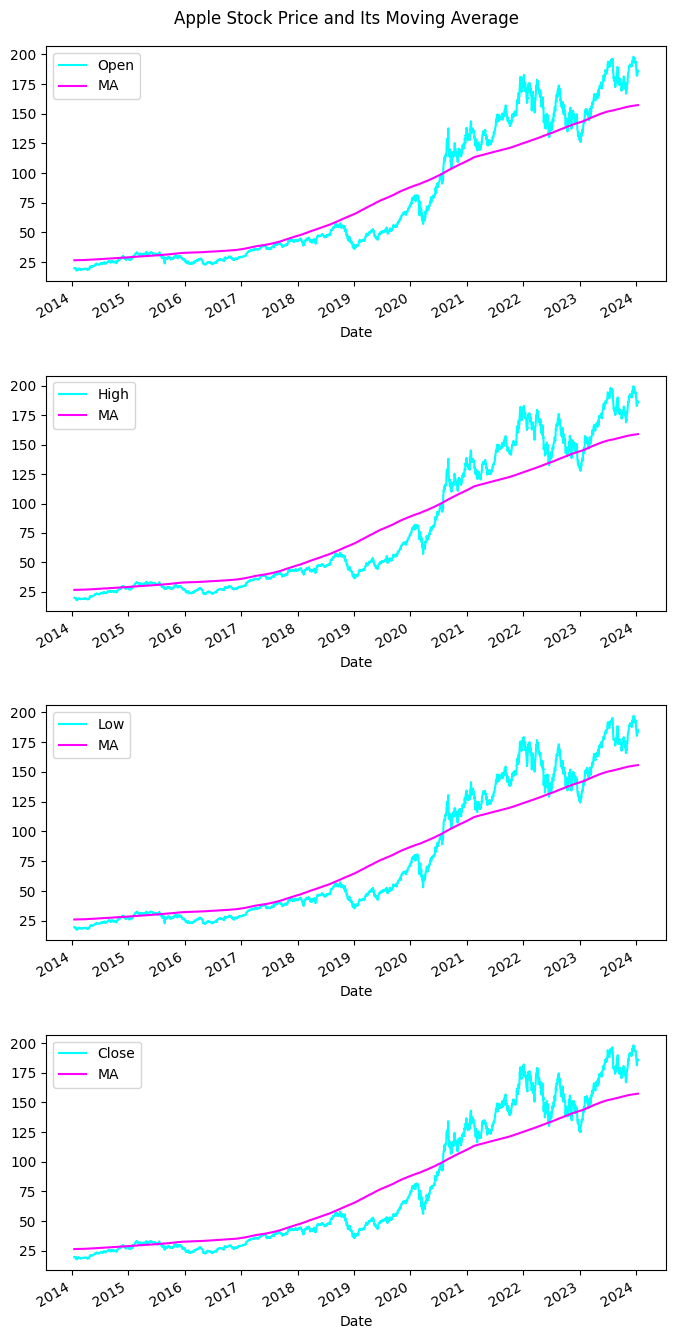

In [10]:
# Genearing moving average for the time series:
# Generating moving average:
for col in apple_columns:
    apple_split[col]["MA"] = ats.moving_average(
        apple_split[col][col],
        730 # <-- the window
    )
    
# Plotting the moving average:
ats.multiplot(
    [ts for ts in apple_split.values()],
    x= "Date", figsize= (8, 18), hspace= 0.4,
    title= r"Apple Stock Price and Its Moving Average",
    title_y= 0.9
)

Now we need to observe the linear dependence between $\mathrm{MA}_Y$ and the $j$-th lag of $\mathrm{MA}_Y$, denoted by $\kappa_j(\mathrm{MA}_Y)$, for every $j \in J$. First, we hypothetically determine

$$
    J := \{182 + k \mid k \in \mathbb{N} \land k \leq 10\} \,.
$$

The linear dependence will be expressed by the partial autocorrelation function (PACF). `AbstrakTS` is equpped with a built in PACF and its plot methods called `pacf` and `pacf_multi_plot`. We will use these methods to show the PACF of $\mathrm{MA}_Y$ and $\kappa_j(\mathrm{MA}_Y)$. The computation is presented in the following cell:

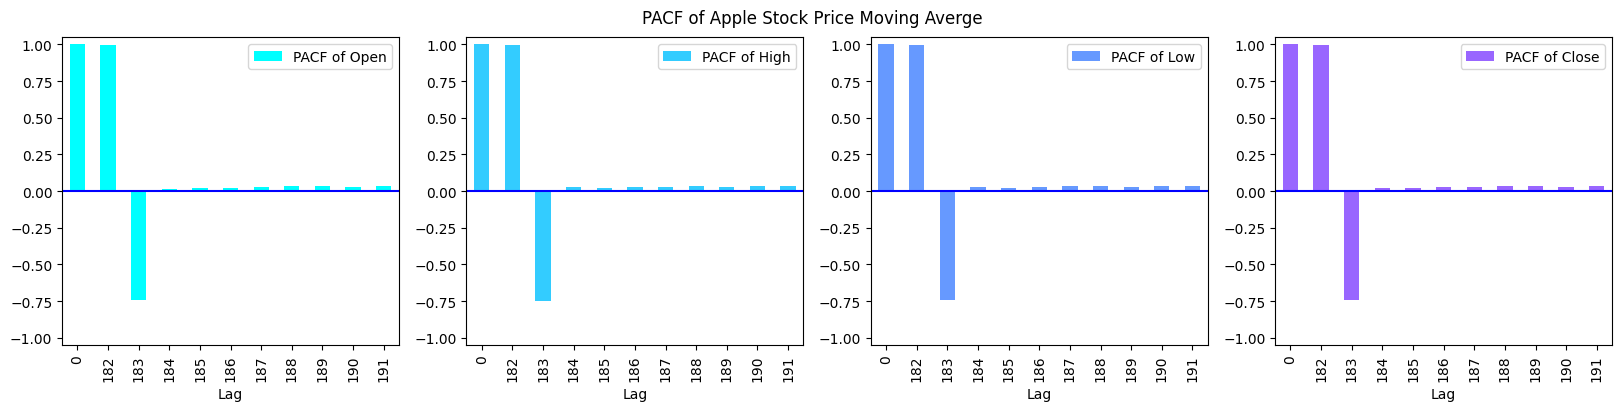

In [11]:
# Finding the best lags for determining trend (tau):
ats.pacf_multi_fig(
    [ts["MA"] for ts in apple_split.values()], # <-- Data of moving average
    [fore_horizon] *len(apple_split),          # <-- List of forecast horizon
    [10] *len(apple_split),                    # <-- The maximum number of lags
    data_id= apple_columns,
    title= "PACF of Apple Stock Price Moving Averge",
    title_y= 0.95, figsize= (20, 4)
)

It can be seen from the plot that the lags with considerable correlation with the moving average are 182 and 183 days. Therefore, we define $J_\tau = \{182, 183\}$. This definition is implemented in the following cell:

In [12]:
# Lags for determining trend:
J_tau = [
    fore_horizon,
    fore_horizon + 1
]

According to the framework of `AbstrakTS`, the function $\tau$ is a composition of a function $\phi$ and the lags, i. e., $\tau = \phi \circ (\kappa_j(\mathrm{MA}_Y))_{j \in J_\tau}$. And the machine learning model representing $\phi$ in `Abstrak` is the method `phi_model`. It is built from Keras' Dense and LSTM layers.

Now we will build the model for determining $\tau$ using `phi_model`. The construction is conducted in the following cell:

In [13]:
# Building model for trend:
trend_models = dict()
valid_index = apple.index[     # <-- The index in apple dataset
    len(apple) - fore_horizon: #     for a validation in the ANN model
]

for col in apple_columns:
    print(f"\nTraining 'phi' model for [{col}]...")
    model, scaler, history = ats.phi_model(
        J_tau,                  # <-- The lags
        apple_split[col]["MA"], # <-- The moving average data
        valid_index,            # <-- Validation index
        # Parameters for ANN:
        with_X= False,
        batch_size= 60,
        epochs= 200
    )
    trend_models[col] = [model, scaler, history]


Training 'phi' model for [Open]...
Epoch 1/200
36/36 [==============================] - 4s 19ms/step - loss: 74.3729 - val_loss: 152.4573
Epoch 2/200
36/36 [==============================] - 0s 5ms/step - loss: 73.1204 - val_loss: 150.9492
Epoch 3/200
36/36 [==============================] - 0s 5ms/step - loss: 71.1877 - val_loss: 148.4409
Epoch 4/200
36/36 [==============================] - 0s 5ms/step - loss: 67.7901 - val_loss: 143.8197
Epoch 5/200
36/36 [==============================] - 0s 5ms/step - loss: 61.2429 - val_loss: 134.8760
Epoch 6/200
36/36 [==============================] - 0s 5ms/step - loss: 48.3515 - val_loss: 113.8310
Epoch 7/200
36/36 [==============================] - 0s 5ms/step - loss: 24.6452 - val_loss: 71.2624
Epoch 8/200
36/36 [==============================] - 0s 5ms/step - loss: 8.5479 - val_loss: 63.3339
Epoch 9/200
36/36 [==============================] - 0s 5ms/step - loss: 8.6709 - val_loss: 63.2157
Epoch 10/200
36/36 [==============================

Now let us observe the performance of the ANN model as follows:

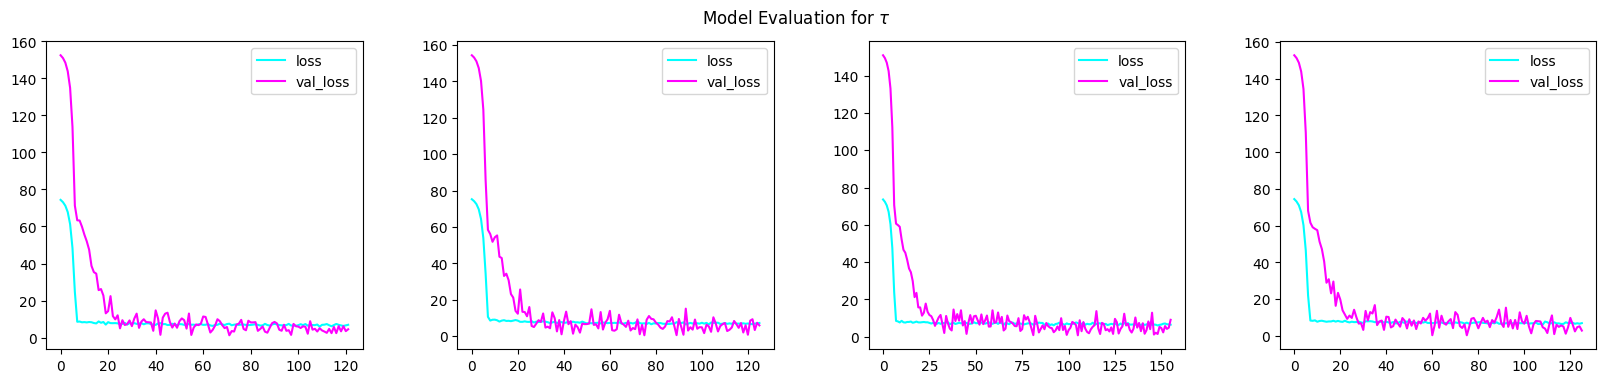

In [14]:
# Evaluation of trend models:
ats.multiplot(
    [tm[2] for tm in trend_models.values()],
    top_bottom= False, figsize= (20, 4),
    title= r"Model Evaluation for $\tau$",
    title_y= 0.96, wspace= 0.3
)

The evaluation shows that the model for $\phi$ is quite satisfactory. Now we proceed for reconstructing the trend on the apple data. For prediction using the model built from `phi_model`, we can use the method `phi_predict`. The computation is conducted in the following cell:

In [15]:
# Reconstructing trends:
for col in apple_columns:
    apple_split[col]["tau"] = list(apple_split[col]["MA"])[:fore_horizon + 1] \
        + list(
            ats.phi_predict(
                J_tau,                  # <-- The lags is an argument
                apple_split[col]["MA"], # <-- The basis data for prediction
                trend_models[col],      # <-- The output of `phi_model
                verbose= False          # <-- Logs turned off
            )
    )

Now we plot the constructed trend $\tau$ together with $Y$ on the original apple data as follows:

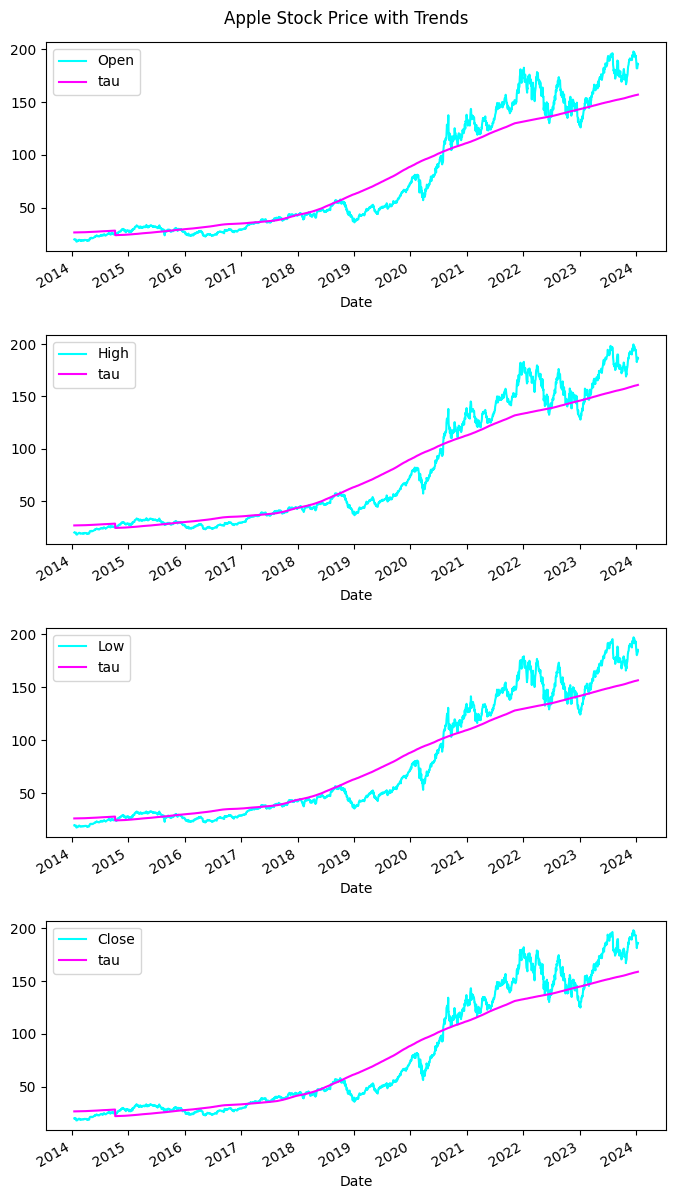

In [16]:
# Plotting reconstructed 'tau' and 'Y':
ats.multiplot(
    [ts for ts in apple_split.values()],
    x= "Date", exclude_columns= ["MA"],
    title= "Apple Stock Price with Trends",
    title_y= 0.9, wspace= None, hspace= 0.4,
    figsize= (8, 16)
)

## **5.2. Determining Secondary Component $(\sigma)$**

Now we proceed for determining the secondary component $\sigma$. As we have mentioned that $\sigma$ is a linear combination of subcomponents $\sigma_1, \dotsc, \sigma_K$, what we are actually going to determine are $\sigma_1, \dotsc, \sigma_K$. We do not know how many will there $K$ be. We will perform an exhaustion on this determination up to the point that $\tilde{Y} := Y - \tau - \sum_{k = 1}^K \sigma_k$ is stationary, meaning that it has a constant moving average and moving variance (equivalently, moving standard deviation).

In fact, obtaining a perfect stationarity for $\tilde{Y}$ is difficult. Instead we use the weak stationary criterion. $\tilde{Y}$ is weak statinoary if there exists some small $\rho_1, \rho_2 > 0$ such that

$$
\mathrm{MA}_{\tilde{Y}}(t) \in \big(c - \rho_1, c + \rho_1\big)
\quad\text{and}\quad
\mathrm{Mstd}_{\tilde{Y}}(t) \in \big(c - \rho_2, c + \rho_2\big)
$$

for every time $t$ in the dataset. Intuitively, the plots of both the expectation moving variance of $\tilde{Y}$ shall be almost flat.

### **5.2.0. Additional Consideration**

If we observe the original time series data, we can see that there is a big jump in the data around 2020. In fact, it is not only big jump of the general value of the time series, but also a relatively larger variance in the time series post 2020. In the real world interptretation, it is clearly an impact of Covid 19 pandemic, which causes higher uncertainty in the market. First, let us observe the following graph to concretely confirm our claim.

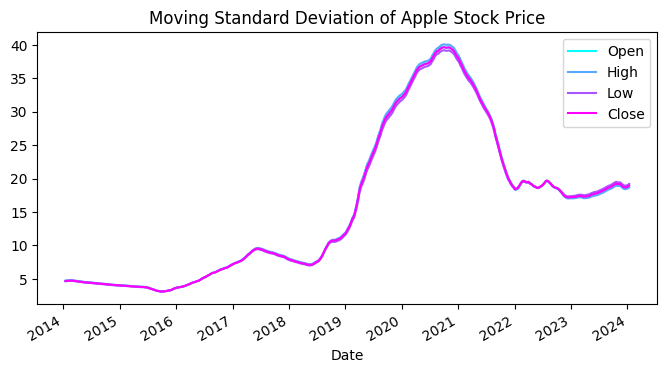

In [17]:
# Moving Standard Deviation:
std_window = 360
std_df = pd.DataFrame(
    {
        'Date': apple["Date"],
        'Open': ats.moving_std(list(apple["Open"]), std_window),
        'High': ats.moving_std(list(apple["High"]), std_window),
        'Low': ats.moving_std(list(apple["Low"]), std_window),
        'Close': ats.moving_std(list(apple["Close"]), std_window)
    }
)

std_df.set_index('Date').plot(
    cmap= "cool",
    title= "Moving Standard Deviation of Apple Stock Price",
    figsize= (8, 4)
);

From the graph above, we can see that the standard deviation (equal to square root of variance) is less than 10 prior to 2019, and is above 15 post post 2020. And very large standard deviations in between 2020 and 2022, which was the period of pandemic. Looking at this data, it seems very unlikely that secondary and seasonal components of the time series on the future would be significantly influenced by the state of the far past (prior to 2019).

Since our concern is forecasting, under this consideration, we decide to use data post 2020 for secondary component and seasonal component. Of course this consideration is rather subjective empirical and intuitive than objective formal.

The slicing of the original dataset for data post 2020 is presented in the following cell:

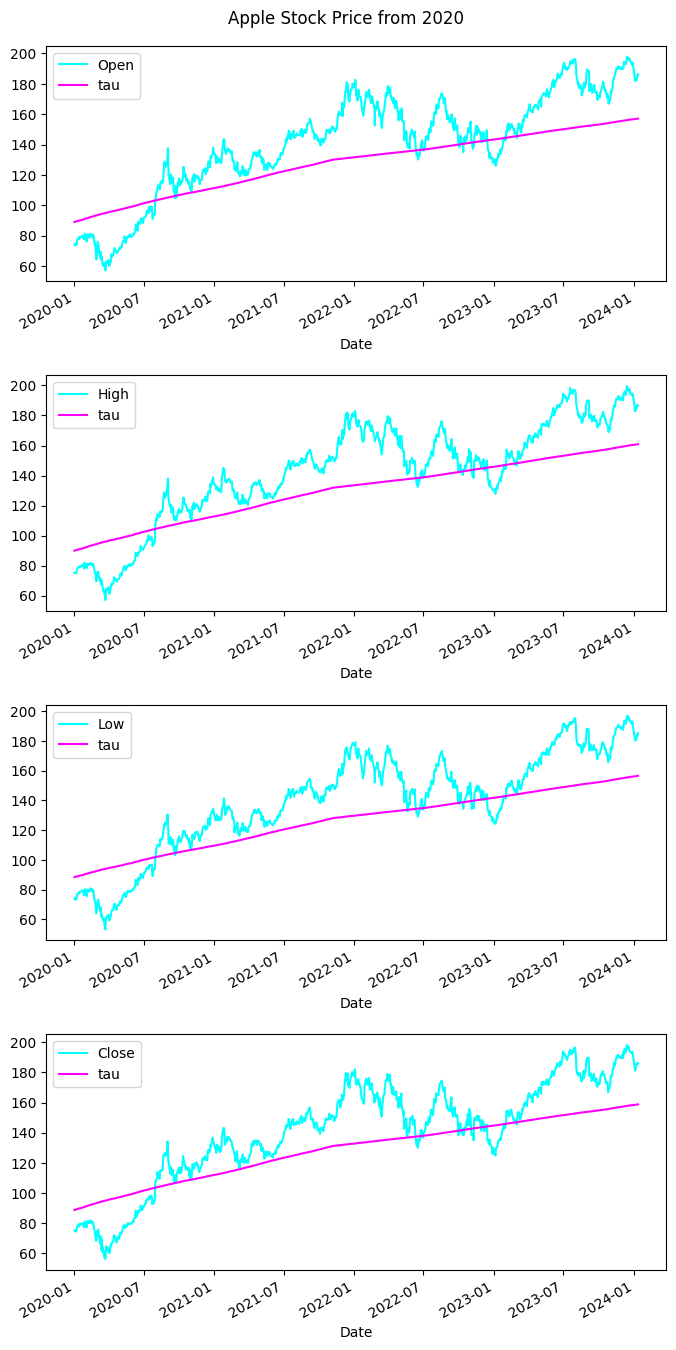

In [18]:
# Slicing the dataset from 2020 and so on:
apple_2020 = {
    col: apple_split[col][
        (apple_split[col]["Date"].isin(pd.date_range("1/1/2020", "1/17/2024")))
    ].copy()
    for col in apple_columns
}

# Visualizing the sliced datasets:
ats.multiplot(
    list(apple_2020.values()), x= "Date",
    exclude_columns= ["MA"],
    figsize= (8, 18), hspace= 0.4,
    title= "Apple Stock Price from 2020",
    title_y= 0.9
)

### **5.2.1. First Secondary Component $(\sigma_1)$**

First, we determine $\sigma_1$. In order to do this, we need to perform detrending on the dataset, that is, subtracting $Y$ from $\tau$, or getting $Y -\tau$. The detrending is conducted in the following cell:

In [19]:
# Detrending the dataset:
for col in apple_columns:
    apple_2020[col]["Y-tau"] = apple_2020[col][col] - apple_2020[col]["tau"]

The visualization of the dataset including the detrended column is presented as follow:

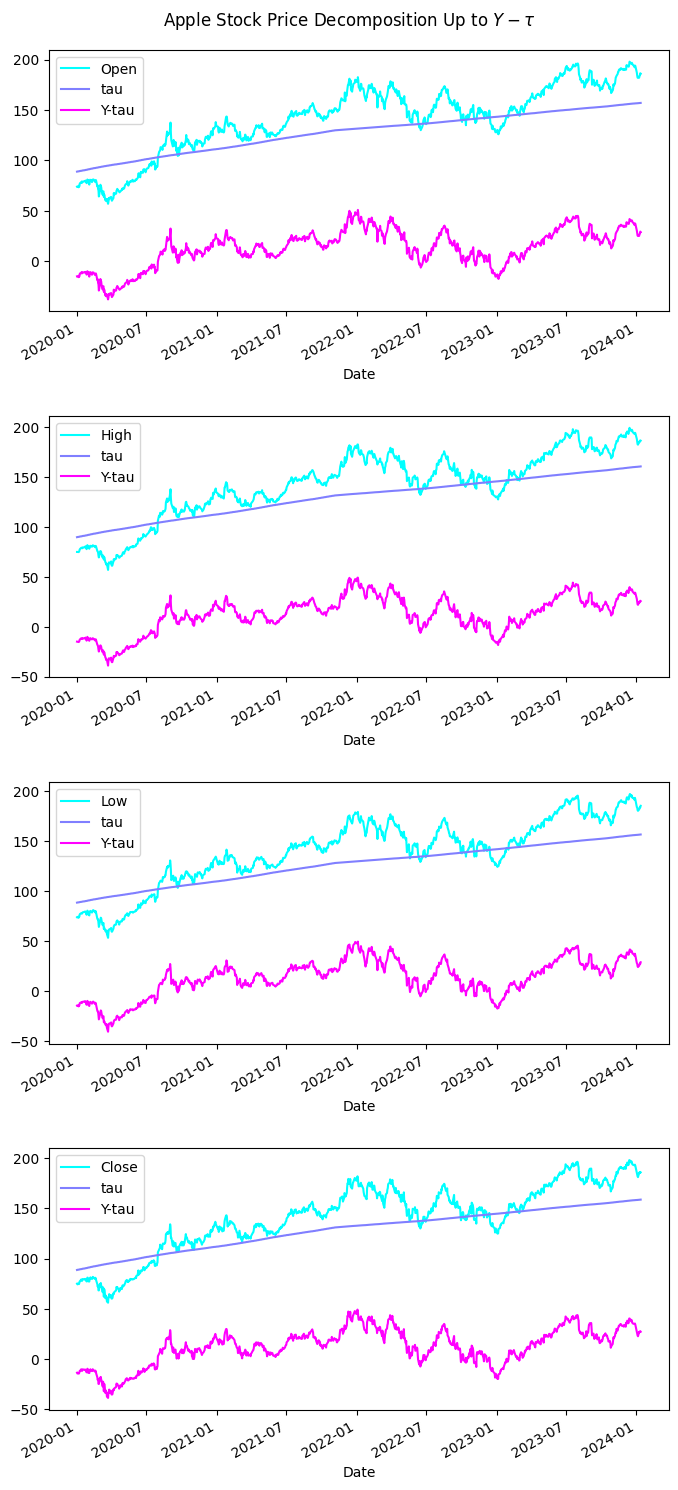

In [20]:
# Visualizing the dataset including `Y-tau`:
ats.multiplot(
    [ts for ts in apple_2020.values()],
    x= "Date", exclude_columns= ["MA"],
    figsize= (8, 20), hspace= 0.4,
    title= r"Apple Stock Price Decomposition Up to $Y -\tau$"
)

In order to decide what model to be use to construct $\sigma_1$, let us compute the moving average of $Y_1 := Y -\tau$ (or $\mathrm{MA}_{Y_1}$) and observe its visualization. Let us use the window of 60 days for the moving average.

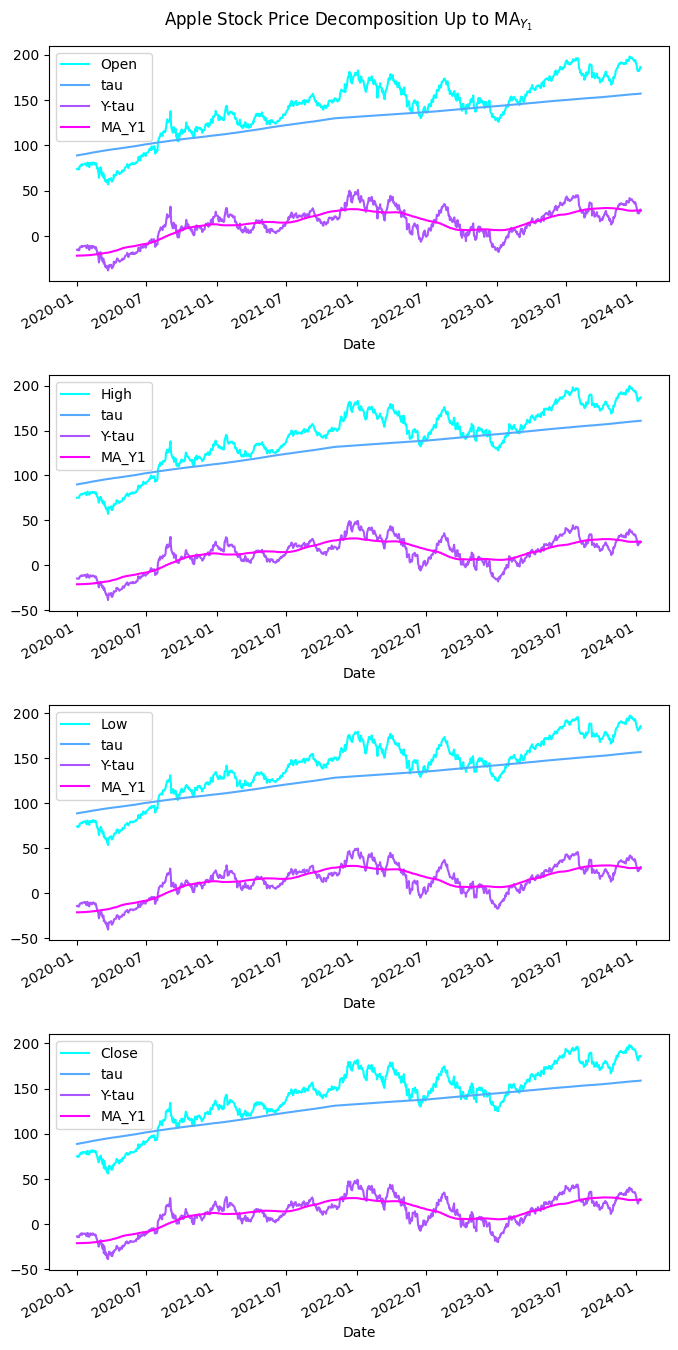

In [21]:
# Computing moving average `Y - tau`:
for col in apple_columns:
    apple_2020[col]["MA_Y1"] = ats.moving_average(
        apple_2020[col]["Y-tau"],
        90    # <-- window
    )
    
# Plotting the dataset including moving average of `Y1`:
ats.multiplot(
    [ts for ts in apple_2020.values()],
    x= "Date", exclude_columns= ["MA"],
    figsize= (8, 18), hspace= 0.4,
    title= r"Apple Stock Price Decomposition Up to $\mathrm{MA}_{Y_1}$"
)

The plot of moving average $\mathrm{MA}_{Y_1}$ suggest an existence of secondary trend in a slightly periodic manner. Now let us compute the PACF of $\mathrm{MA}_{Y_1}$ and plot it. The computation is presented as follows:

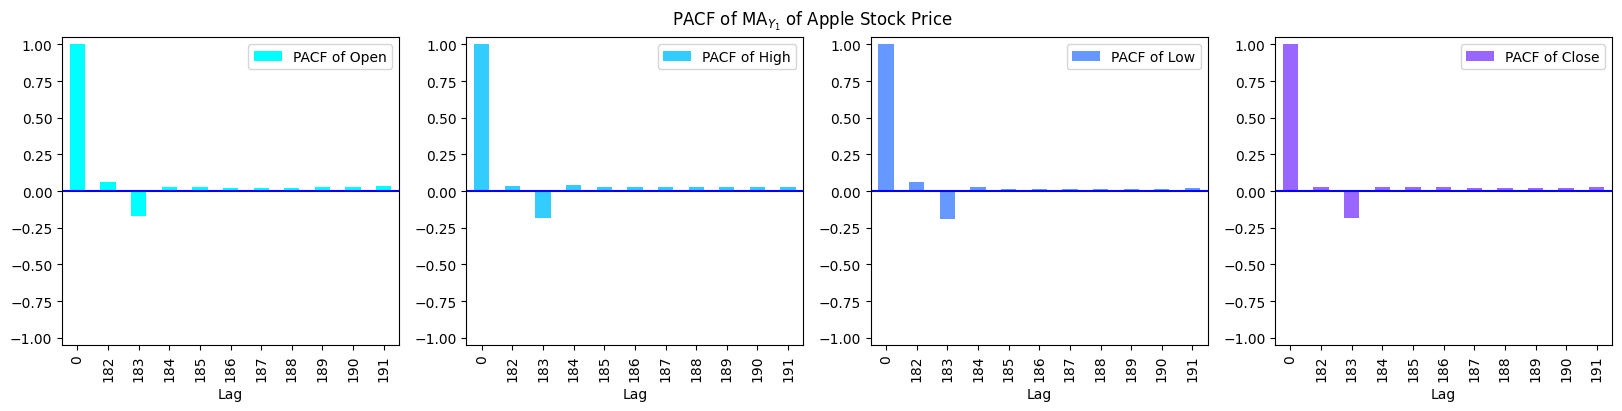

In [22]:
# PACF of MA_Y1:
ats.pacf_multi_fig(
    [ts["MA_Y1"] for ts in apple_2020.values()],
    [fore_horizon] *len(apple_2020),
    [10] *len(apple_2020),
    data_id= apple_columns,
    title= r"PACF of $\mathrm{MA}_{Y_1}$ of Apple Stock Price",
    title_y= 0.95,
    figsize= (20, 4)
)

The plots of PACF shows that lag 183 is the most significant for the model. Now we build the model for $\sigma_1$ from the method `phi_model` of `AbstrakTS`. The computation is presented as follows:

In [23]:
# Model for sigma-1:
J_sig1 = [
    fore_horizon,
    fore_horizon + 1
]
valid_index_2020 = apple_2020["Open"].index[-fore_horizon + 1:]

sec1_models = dict()

for col in apple_columns:
    print(f"\nTraining 'phi' model of sigma-1 for [{col}]...")
    model, scaler, history = ats.phi_model(
        J_sig1,
        apple_2020[col]["MA_Y1"],
        valid_index_2020,
        with_X= False,
        first_layer_units= 100,
        batch_size= 60,
        epochs= 200,
        verbose= 1
    )
    sec1_models[col] = [model, scaler, history]


Training 'phi' model of sigma-1 for [Open]...
Epoch 1/200
11/11 [==============================] - 2s 49ms/step - loss: 16.1751 - val_loss: 26.7374
Epoch 2/200
11/11 [==============================] - 0s 7ms/step - loss: 15.9309 - val_loss: 26.4237
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 15.6029 - val_loss: 26.0906
Epoch 4/200
11/11 [==============================] - 0s 7ms/step - loss: 15.2625 - val_loss: 25.7280
Epoch 5/200
11/11 [==============================] - 0s 7ms/step - loss: 14.9005 - val_loss: 25.3241
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 14.4154 - val_loss: 24.8632
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 13.9861 - val_loss: 24.3318
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 13.3840 - val_loss: 23.7128
Epoch 9/200
11/11 [==============================] - 0s 7ms/step - loss: 12.7332 - val_loss: 22.9842
Epoch 10/200
11/11 [=======================

The evaluation of the model is presented in the following graphs:

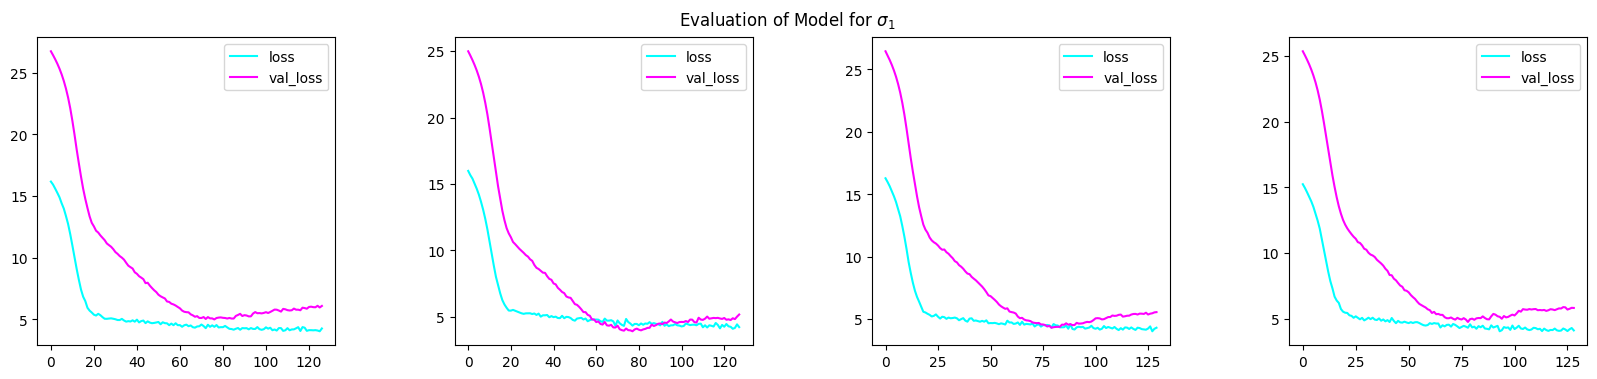

In [24]:
ats.multiplot(
    [sm[2] for sm in sec1_models.values()],
    top_bottom= False,
    figsize= (20, 4), hspace= 0.4,
    title= r"Evaluation of Model for $\sigma_1$",
    title_y= 0.95
)

The evaluation shows a satisfactory result for the model of $\sigma_1$. Now let us reconstruct $\sigma_1$ on the data from 2020.

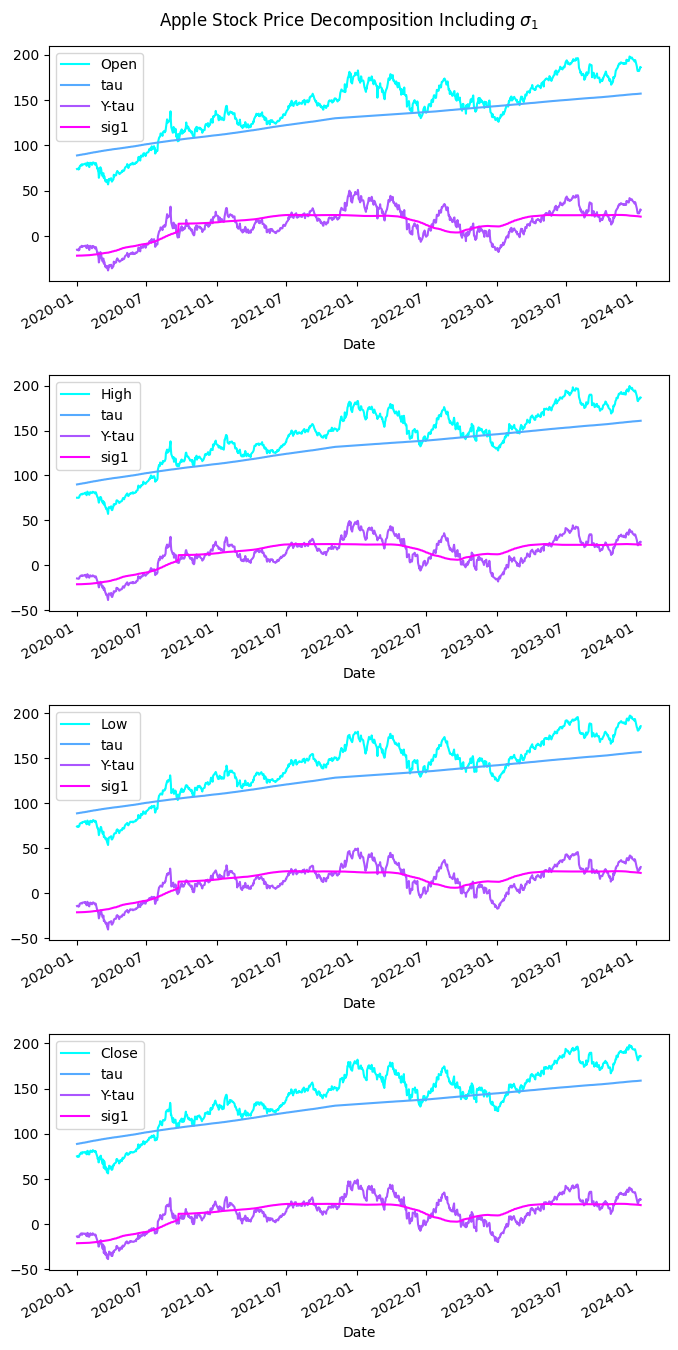

In [25]:
# Reconstructing sigma-1:
for col in apple_columns:
    apple_2020[col]["sig1"] = list(apple_2020[col]["MA_Y1"])[:J_sig1[-1]] \
        + list(
            ats.phi_predict(
                J_sig1,
                apple_2020[col]["MA_Y1"],
                sec1_models[col],
                verbose= False
            )
    )
    
# Visualization of apple stock price including sigma-1:
ats.multiplot(
    list(apple_2020.values()), x= "Date",
    exclude_columns= ["MA", "MA_Y1"],
    figsize= (8, 18), hspace= 0.4,
    title= r"Apple Stock Price Decomposition Including $\sigma_1$",
    title_y= 0.9
)

### **5.2.2. Second Secondary Component $(\sigma_2)$**

Now we will determine the second secondary component $\sigma_2$. Let us start by subtracting $Y_1 = Y -\tau$ from $\sigma_1$ $\Big($in other words, getting $Y_2 := Y -\tau -\sigma_1 \Big)$.

The computation is conducted in the following cell:

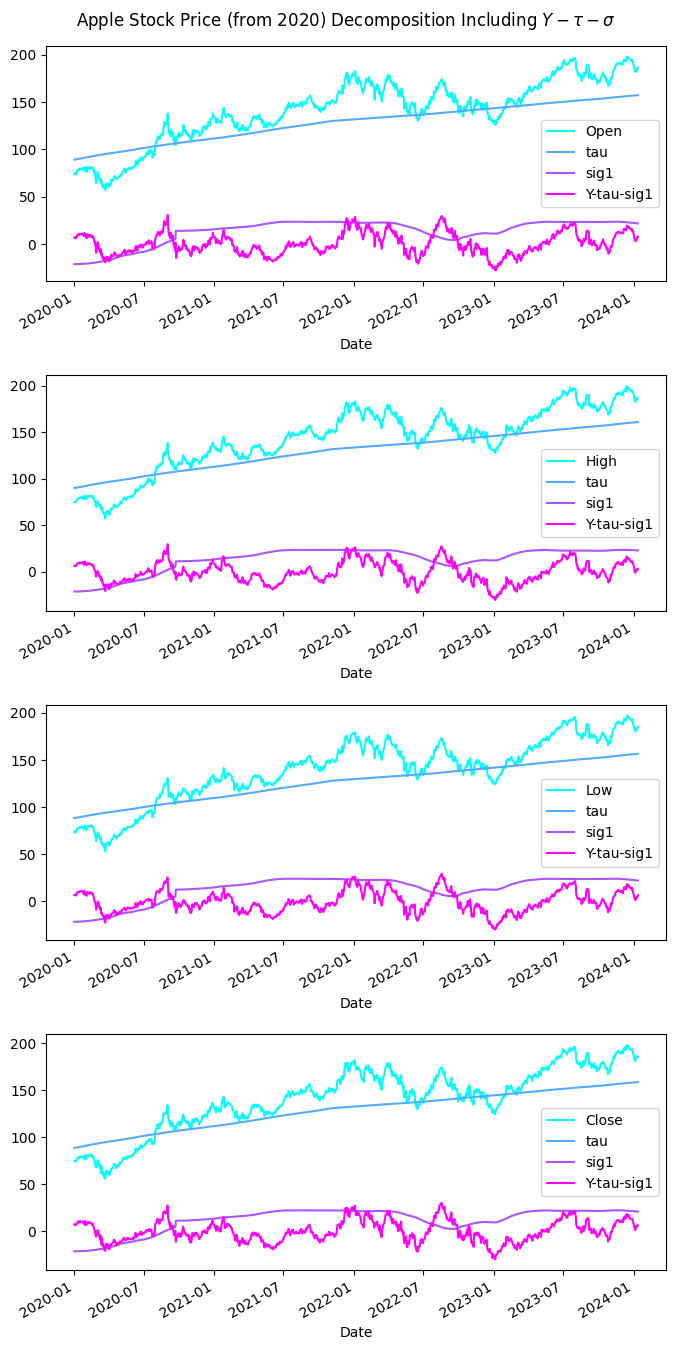

In [26]:
# Computing Y2:
for col in apple_columns:
    apple_2020[col]["Y-tau-sig1"] = apple_2020[col]["Y-tau"] \
        -apple_2020[col]["sig1"]
    
# Visualizing data sets including Y2:
ats.multiplot(
    list(apple_2020.values()),
    x= "Date", exclude_columns= ["MA", "MA_Y1", "Y-tau"],
    figsize= (8, 18), hspace= 0.4,
    title= r"Apple Stock Price (from 2020) Decomposition Including $Y -\tau -\sigma$",
    title_y= 0.9
)

If we observe the graph above, we can tell that $Y_2 = Y_1 -\sigma_1$ forms a periodic pattern. Therefore, we will use a wave model for $\sigma_2$. This model can be built from a method `psi_model` in `AbstrakTS`. The computation is conducted in the following cell:

In [27]:
# Model for sigma-2:
sec2_models = dict()

for col in apple_columns:
#   Method `psi_model` has three ouputs in forms of a triple,
#   namely; `(model, n_cycle, L, loss_cycle)`.
#   `model` is the model itself;
#   ` n_cycle` is the best number of cycle of sinusiodal waves
#   computed by the algorithm;
#   `L` is another parameter similar to the length of observed data;
#   and `loss_cycle` is a dictionary consiting of loss scores with
#   respect to the cycles.
    model, n_cycle, L, loss_cycle = ats.psi_model(
        apple_2020[col]["Y-tau-sig1"],  # <-- The data in use for model
        20,                             # <-- Limit number of cycles
        valid_index_2020                # <-- Index of validation
    )
    sec2_models[col] = [model, n_cycle, L, loss_cycle]

Now let us reconstruct $\sigma_2$ on the data from 2020. We can use the method `psi_predict` for executing the prediction for $\sigma_2$. The computation is conducted in the following cell:

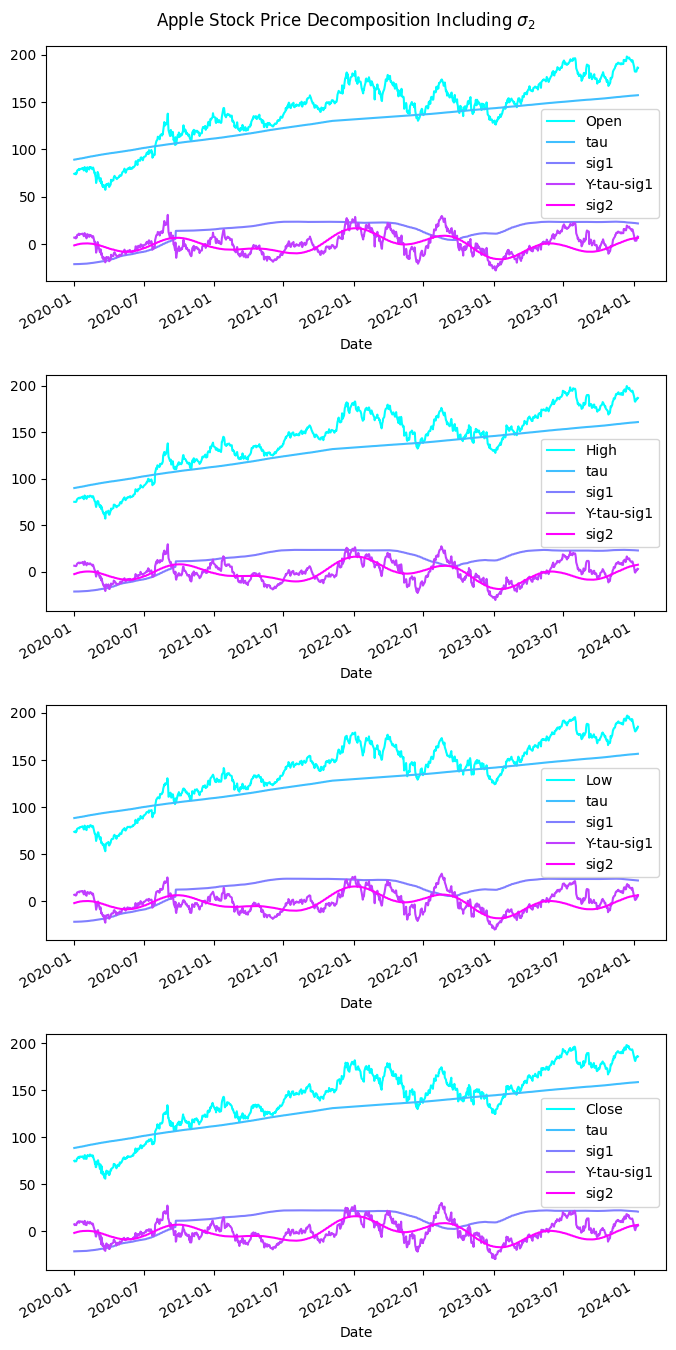

In [28]:
# Reconstructing sigma-2:
for col in apple_columns:
    apple_2020[col]["sig2"] = ats.psi_predict(
        apple_2020[col]["Y-tau-sig1"].index,
        sec2_models[col]
    )
    
# Visualizing the current decomposition:
ats.multiplot(
    list(apple_2020.values()), x= "Date",
    exclude_columns= ["MA", "Y-tau", "MA_Y1"],
    figsize= (8, 18), hspace= 0.4,
    title= r"Apple Stock Price Decomposition Including $\sigma_2$",
    title_y= 0.9
)

It can be seen from the graphs above that $\sigma_2$ fits the smoothen $Y_1 -\sigma_1$, which means that $\sigma_2$ provides a good explainability on $Y_1 -\sigma_1$. We can consider this result satisfactory.

Now let us subtract $Y_2 := Y_1 -\sigma_1$ from $\sigma_2$ (or getting $Y_3 := Y_2 - \sigma_2$), and findout whether $Y_2$ is weak stationary.

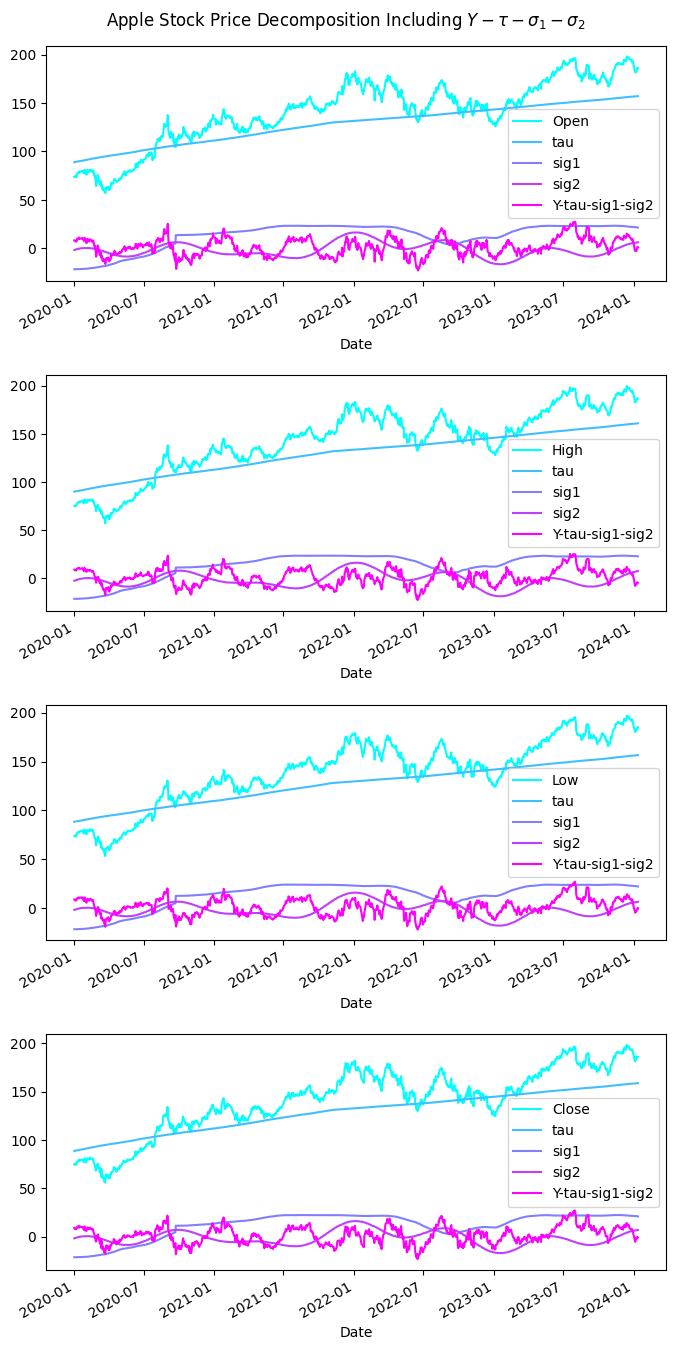

In [29]:
# Constructing Y2:
for col in apple_columns:
    apple_2020[col]["Y-tau-sig1-sig2"] = apple_2020[col]["Y-tau-sig1"] \
        -apple_2020[col]["sig2"]
    
# Visualizing the current decomposition:
ats.multiplot(
    list(apple_2020.values()), x= "Date",
    exclude_columns= ["MA", "Y-tau", "MA_Y1", "Y-tau-sig1"],
    figsize= (8, 18), hspace= 0.4,
    title= r"Apple Stock Price Decomposition Including $Y-\tau-\sigma_1-\sigma_2$",
    title_y= 0.9
)

The graphs of $Y_3$ above indicate weak stationarity. If this is the case, then we truncate the number of secondary sub-components into $K = 2$, and thus, $\sigma = \sigma_1 + \sigma_2$, and we will proceed for constructing the seasonality.

However, let us concretely confirm our suspicion by computing the moving average $\mathrm{MA}_{Y_3}$ and moving standard deviation $\mathrm{MV}_{Y_3}$ of $Y_3$. If both the moving average and moving standard deviation are almost constant, we can consider $Y_3$ to be weak stationary.

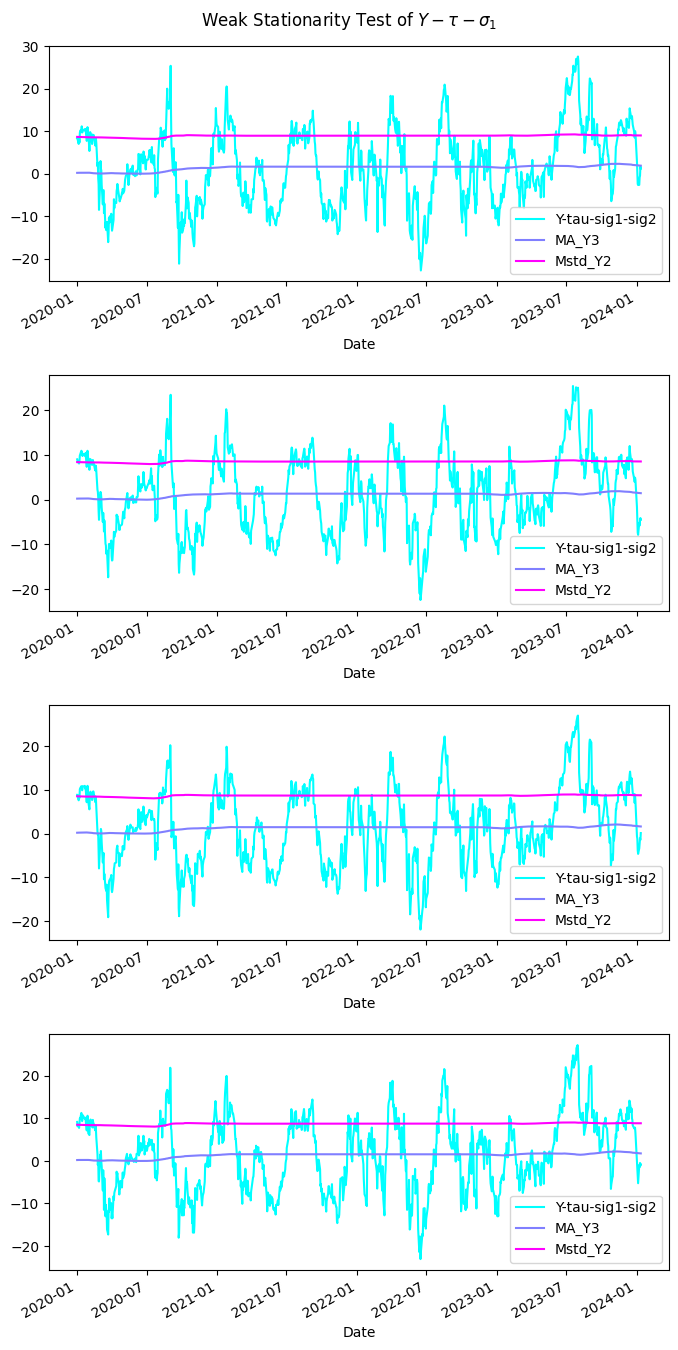

In [30]:
# Computing the weak stationarity of Y3:
def weak_stat(w= 182):
    df_list = [df.copy() for df in apple_2020.values()]
    for df in df_list:
        df["MA_Y3"] = ats.moving_average(df["Y-tau-sig1-sig2"], w)
        df["Mstd_Y2"] = ats.moving_std(df["Y-tau-sig1-sig2"], w)
        cols = list(df.columns)
        cols[1] = "Y"
        df.columns = cols
    
    ats.multiplot(
        df_list, x= "Date",
        exclude_columns= [
            "Y", "tau", "MA", "Y-tau",
            "MA_Y1", "sig1", "Y-tau-sig1",
            "sig2",
        ],
        figsize= (8, 18), hspace= 0.4,
        title= r"Weak Stationarity Test of $Y-\tau-\sigma_1$",
        title_y= 0.9
    )
    
weak_stat(w= 2 *365)

The graphs of $\mathrm{MA}_{Y_3}$ and $\mathrm{Mstd}_{Y3}$ above are relatively flat. This results indicate a weak stationarity on $Y-\tau-\sigma_1$. Thus, it is confirmed that $K = 2$. Therefore, we proceed for the seasonality.

## **5.3. Determining Seasonal Component $(\varsigma)$**

The seasonality technique used in this computation is called modulo seasonality, which is implemented within the architecture of `AbstrakTS`. The theory of modulo seasonality generalizes seasonalities beyond the domain of time sequence, but also to any ordered sequence data. The framework of this technique is an implementation of modular arithmetic.

First, the parameter that we to need find is the proper divisors (acting as periods) to generate additional features called modulo seasonal features. The computation is conducted in the following cell:

In [31]:
# Finding the proper divisors:
modulo_features = {
    col: ats.find_modulo_season(
        apple_2020[col]["Y-tau-sig1-sig2"],
        365,        # <-- Maximum largest divisor 
        num_p= 40   # <-- Limit number of features
    )
    for col in apple_columns
}

To intuitively confirm that the divisors are indeed proper divisors, let us graph the scatter plot between the created features and $Y-\tau-\sigma_1-\sigma_2$. The computation is conducted in the following cell:

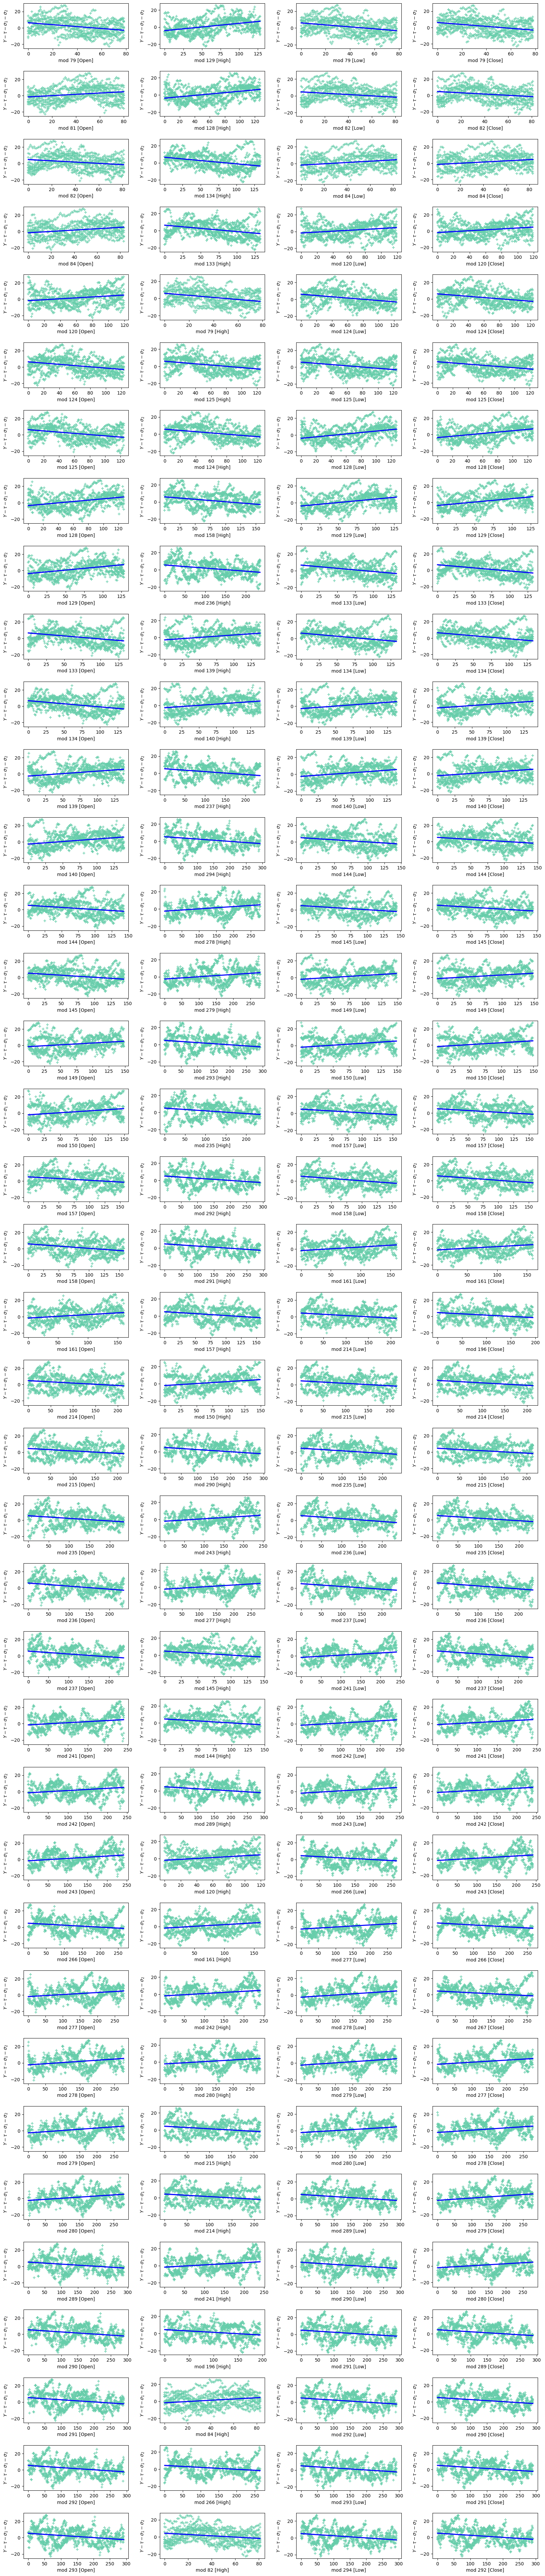

In [32]:
# Plotting the scatter plot of modulo features:

# Function for plotting:
def plot_modulo_season(
        ts_list, mod_features, ylabel,
        figsize= (20, 30),
        wspace= 0.3, hspace= 0.5
        ):
    kys = mod_features.keys()
    N = len(mod_features)
    M = min(
        [
            len(mod_features[ke][0].columns)
            for ke in mod_features.keys()
            ]
        )
    fig, axes = plt.subplots(
        nrows= M, ncols= N, figsize= figsize
    )
    for i in range(N):
        ke = list(mod_features.keys())[i]
        df = mod_features[ke][0].copy()
        cols = df.columns
        for j in range(M):
            fig = sns.regplot(
                x= df[cols[j]], y= ts_list[i],
                color= "mediumaquamarine", marker= "+",
                line_kws= dict(color="blue"),
                ax= axes[j][i]
            )
            axes[j][i].set(
                xlabel= f"{cols[j]} [{apple_columns[i]}]",
                ylabel= ylabel
            )
    fig = plt.subplots_adjust(
        wspace= wspace, hspace= hspace
        )
    fig = plt.show()
    
# Plotting the relation
plot_modulo_season(
    [ts["Y-tau-sig1-sig2"] for ts in apple_2020.values()],
    modulo_features,
    r"$Y-\tau-\sigma_1-\sigma_2$",
    figsize= (20, 100)
)

The graphs show a strong linear relationship between each feature of divisor and $Y_3$. Therefore, the divisors are proper, and let us proceed for building the model for $\varsigma$.

We can use a method `eta_ann_model` for constructing the model for $\varsigma$. The compuation is conducted in the following cell:

In [33]:
# Model for seasonality:
modulo_seasonal_models = dict()

for col in apple_columns:
    print(f"\nTraining 'eta' model for seasonality of [{col}]...")
    model, scaler, history = ats.eta_ann_model(
        modulo_features[col][0],
        apple_2020[col]["Y-tau-sig1-sig2"],
        valid_index_2020,
        first_units= 2500,
        num_hidden_layers= 5,
        hidden_units= 2500,
        batch_size= 30,
        epochs= 80,
        verbose= 1
    )
    modulo_seasonal_models[col] = [model, scaler, history]


Training 'eta' model for seasonality of [Open]...
Epoch 1/80
28/28 [==============================] - 4s 29ms/step - loss: 5.3297 - val_loss: 10.1749
Epoch 2/80
28/28 [==============================] - 0s 13ms/step - loss: 4.6441 - val_loss: 8.2717
Epoch 3/80
28/28 [==============================] - 0s 11ms/step - loss: 4.2623 - val_loss: 9.0640
Epoch 4/80
28/28 [==============================] - 0s 11ms/step - loss: 4.2384 - val_loss: 10.0097
Epoch 5/80
28/28 [==============================] - 0s 11ms/step - loss: 4.2127 - val_loss: 8.5938
Epoch 6/80
28/28 [==============================] - 0s 11ms/step - loss: 3.8119 - val_loss: 9.3292
Epoch 7/80
28/28 [==============================] - 0s 11ms/step - loss: 3.9537 - val_loss: 9.1059
Epoch 8/80
28/28 [==============================] - 0s 11ms/step - loss: 3.9449 - val_loss: 8.8349
Epoch 9/80
28/28 [==============================] - 0s 11ms/step - loss: 3.7966 - val_loss: 8.8676
Epoch 10/80
28/28 [==============================] - 0s 

Let us observe the evaluation of the model for $\varsigma$ on the following graphs:

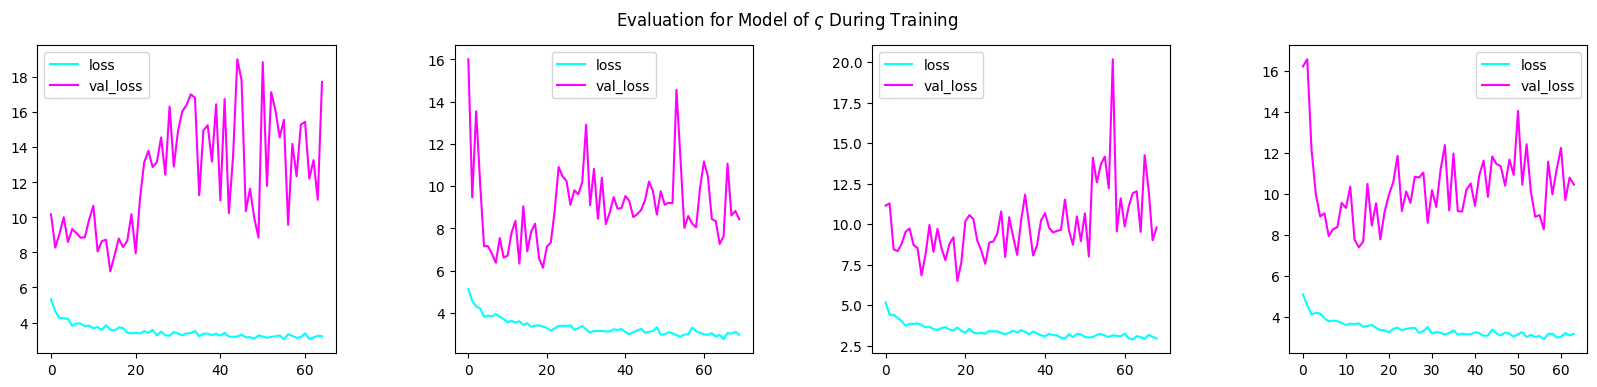

In [34]:
# Evaluation for model of varsgima:
ats.multiplot(
    [mod[2] for mod in modulo_seasonal_models.values()],
    top_bottom= False, figsize= (20, 4),
    title= r"Evaluation for Model of $\varsigma$ During Training",
    title_y= 0.97
)

Now let us reconstruct $\varsigma$ on the dataset. The prediction using models built from `eta_ann_model` can be executed using a method `eta_ann_predict` in `AbstrakTS`. The computation is conducted in the following cell:

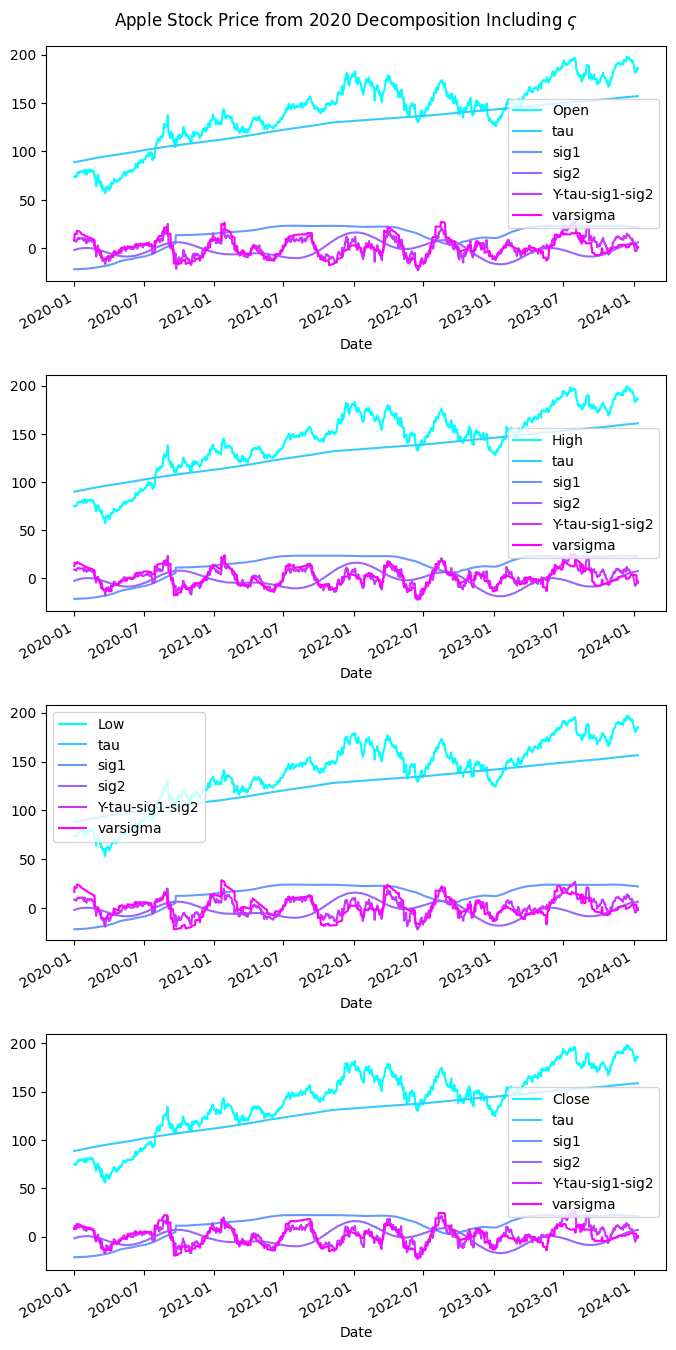

In [35]:
# Reconstructing varsigma:
for col in apple_columns:
    apple_2020[col]["varsigma"] = ats.eta_ann_predict(
        modulo_features[col][0],
        modulo_seasonal_models[col]
    )
    
# Visualising the current decomposition:
ats.multiplot(
    list(apple_2020.values()), x= "Date",
    exclude_columns= [
        "MA", "Y-tau", "MA_Y1",
        "Y-tau-sig1",
#         "Y-tau-sig1-sig2"
    ],
    figsize= (8, 18), hspace= 0.4,
    title= r"Apple Stock Price from 2020 Decomposition Including $\varsigma$",
    title_y= 0.9
)

The reconstruction of $\varsigma$ shows a quite representation on $Y_3$. 

## **5.4. Residual**

Let us observe the residual. The residual is given by $\varepsilon = Y - \tau - \sigma_1 - \sigma_2 - \varsigma$. The computation is conducted as follows.

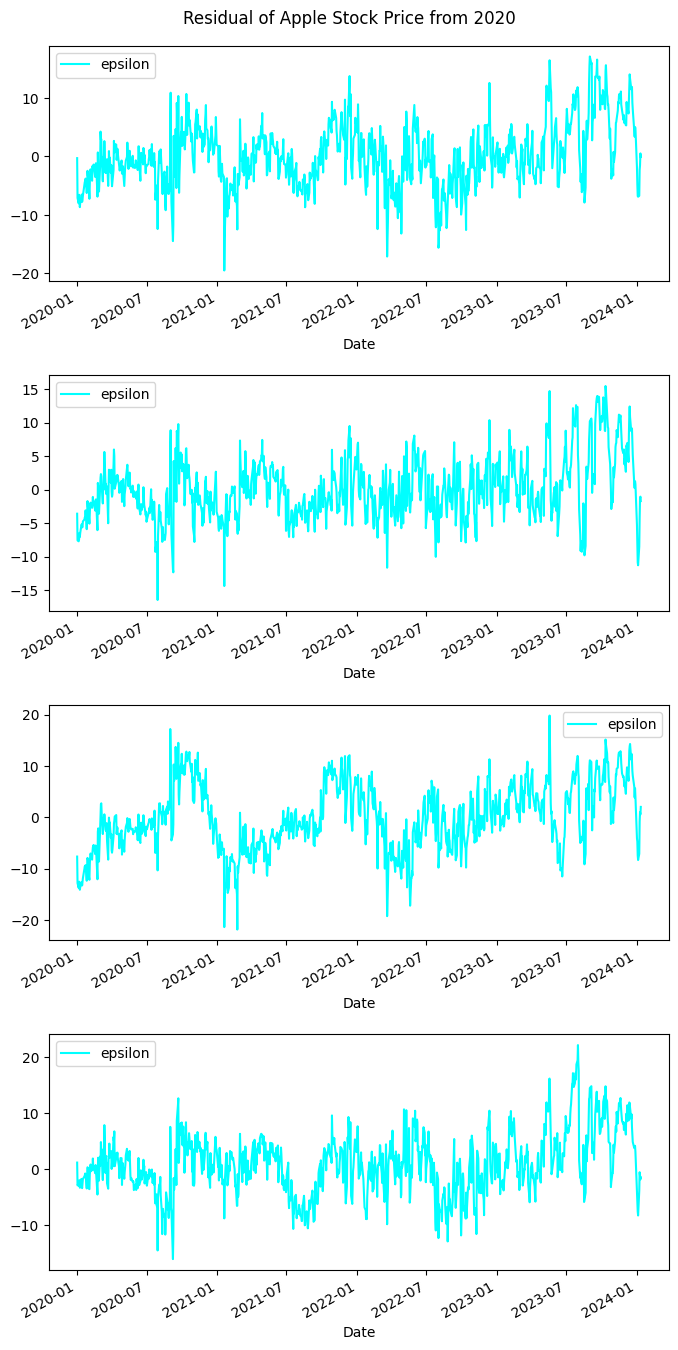

In [36]:
# Constructing the residual:
for col in apple_columns:
    apple_2020[col]["epsilon"] = apple_2020[col]["Y-tau-sig1-sig2"] \
        -apple_2020[col]["varsigma"]
    
# Visualization of current decomposition:
def visualize_epsilon():
    df_dict = {col: apple_2020[col].copy() for col in apple_columns}
    for col in apple_columns:
        cols = [c for c in df_dict[col].columns]
        cols[1] = "Y"
        df_dict[col].columns = cols
    ats.multiplot(
        list(df_dict.values()), x= "Date",
        exclude_columns= [
            'Y', 'MA', 'tau', 'Y-tau', 'MA_Y1', 'sig1',
            'Y-tau-sig1', 'sig2', 'Y-tau-sig1-sig2',
            'varsigma'
        ],
        figsize= (8, 18), hspace= 0.4,
        title= r"Residual of Apple Stock Price from 2020",
        title_y= 0.9
    )
    
visualize_epsilon()

## **5.5. Forecasting**

We will perform a forecasting of Apple Inc stock price for the 6 months ahead, or 182 days. The input variables for the forecast is designated in the following cell:

In [37]:
# Forecasting apple stock prices:
apple_fore_dict = dict()
forecast_index = [
    apple_2020["Open"].index[-1] + k
    for k in range(fore_horizon + 1)
]
for col in apple_columns:
    # Forecasting trend (tau):
    tau_fore = ats.phi_predict(
        J_tau, apple_2020[col]["MA"], trend_models[col],
        forecast= True, normalized= True, lstm= True, verbose= False
    )
    
    # Forecasting sigma-1:
    sig1_fore = ats.phi_predict(
        J_sig1, apple_2020[col]["MA_Y1"], sec1_models[col],
        forecast= True, normalized= True, lstm= True, verbose= False
    )
    
    # Forecasting sigma-2:
    sig2_fore = ats.psi_predict(
        forecast_index, sec2_models[col]
    )
    
    # Forecasting seasonality:
    varsig_fore = ats.eta_ann_predict(
        ats.modulo_seasonal_features(
            forecast_index,
            modulo_features[col][1]["p"]
        ),
        modulo_seasonal_models[col],
        verbose= False
    )
    
    # Forecasting the stock prices:
    Y_fore = tau_fore + sig1_fore + sig2_fore + varsig_fore
    apple_fore_dict[col] = Y_fore
    
fore_date = pd.date_range(
    start= "1/12/2024",
    periods= len(forecast_index),
    freq= "B"
)
apple_fore = pd.DataFrame({"Date": fore_date})
for col in apple_columns:
    apple_fore[col] = apple_fore_dict[col]

The visualization of the forecast on Apple stock price is presented in the follownig graph:

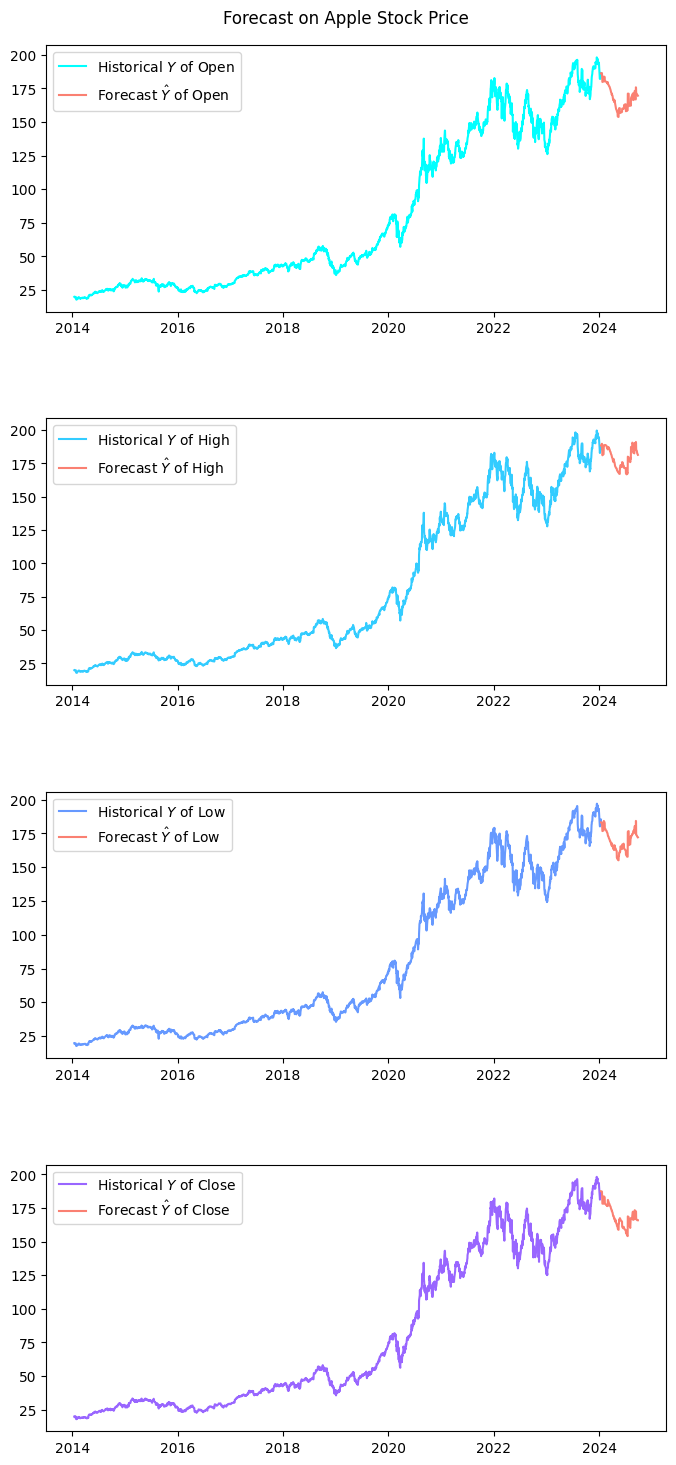

In [38]:
# Apple stock price forecast:
apple_fig, apple_axes = plt.subplots(
    nrows= len(apple_columns), ncols= 1, figsize= (8, 18)
)
for k, col in zip(range(len(apple_columns)), apple_columns):
    apple_axes[k].plot(
        apple["Date"], apple[col],
        color= plt.cm.cool(k / (len(apple_columns) + 1)),
        label= fr"Historical $Y$ of {col}"
    )
    apple_axes[k].plot(
        apple_fore["Date"], apple_fore[col],
        color= "salmon",
        label= r"Forecast $\hat{Y}$" + f" of {col}"
    )
    apple_axes[k].legend()
apple_fig = plt.subplots_adjust(hspace= 0.4)
apple_fig = plt.suptitle("Forecast on Apple Stock Price", y= 0.9)
apple_fig = plt.show()

# **6. Conclusion**

We have demonstrate the use of Python package `AbstrakTS` for forecacsting Apple stock price. The package is still under an intensive development. If you are interested using the package, you can install the package on your notebook by applying the following command:
```
!pip install git+https://github.com/rizalpurnawan23/AbstrakTS.git
```
Then you can import the package using the following command:
```
from abstrakTS.abstrakTS import AbstrakTS
```
We really appreciate any feedback for the development of the package. We hope we can improve the usability and the functionality of the package to help perform time series forecasting.
This is the end of the discussion.